# ARIMA model for predict today's tesla stock price (yejin)

- reference 

: https://www.youtube.com/watch?v=rsva2qmhGyE (Predict Stock Price using ARIMA model (Python))

: https://www.youtube.com/watch?v=gqryqIlvEoM (How to Choose the p, d, q Terms to Build ARIMA Model)

- book 52p (pdf 77p) : identifying MA order by looking ACF. 
- book 59p : EACF for ARMA 
- book 68p : Differncing(ARIMA)

- Python(pyenv 3.11.11)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
import datetime
import warnings

warnings.filterwarnings("ignore")

In [2]:
#import tesla data
ticker = 'TSLA'
data = yf.Ticker(ticker)
data

yfinance.Ticker object <TSLA>

In [3]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=730)
tomorrow = end_date + datetime.timedelta(days=1)
prices = data.history(start=start_date,end=end_date).Close
prices

Date
2023-03-27 00:00:00-04:00    191.809998
2023-03-28 00:00:00-04:00    189.190002
2023-03-29 00:00:00-04:00    193.880005
2023-03-30 00:00:00-04:00    195.279999
2023-03-31 00:00:00-04:00    207.460007
                                ...    
2025-03-18 00:00:00-04:00    225.309998
2025-03-19 00:00:00-04:00    235.860001
2025-03-20 00:00:00-04:00    236.259995
2025-03-21 00:00:00-04:00    248.710007
2025-03-24 00:00:00-04:00    278.390015
Name: Close, Length: 500, dtype: float64

In [4]:
print(end_date)
print(tomorrow)

2025-03-25
2025-03-26


In [5]:
prices.describe()

count    500.000000
mean     242.570980
std       68.015539
min      142.050003
25%      189.110001
50%      234.255005
75%      260.464996
max      479.859985
Name: Close, dtype: float64

In [6]:
#calculate returns
returns = prices.pct_change().dropna()
returns

Date
2023-03-28 00:00:00-04:00   -0.013659
2023-03-29 00:00:00-04:00    0.024790
2023-03-30 00:00:00-04:00    0.007221
2023-03-31 00:00:00-04:00    0.062372
2023-04-03 00:00:00-04:00   -0.061168
                               ...   
2025-03-18 00:00:00-04:00   -0.053359
2025-03-19 00:00:00-04:00    0.046824
2025-03-20 00:00:00-04:00    0.001696
2025-03-21 00:00:00-04:00    0.052696
2025-03-24 00:00:00-04:00    0.119336
Name: Close, Length: 499, dtype: float64

Text(0, 0.5, 'Returns')

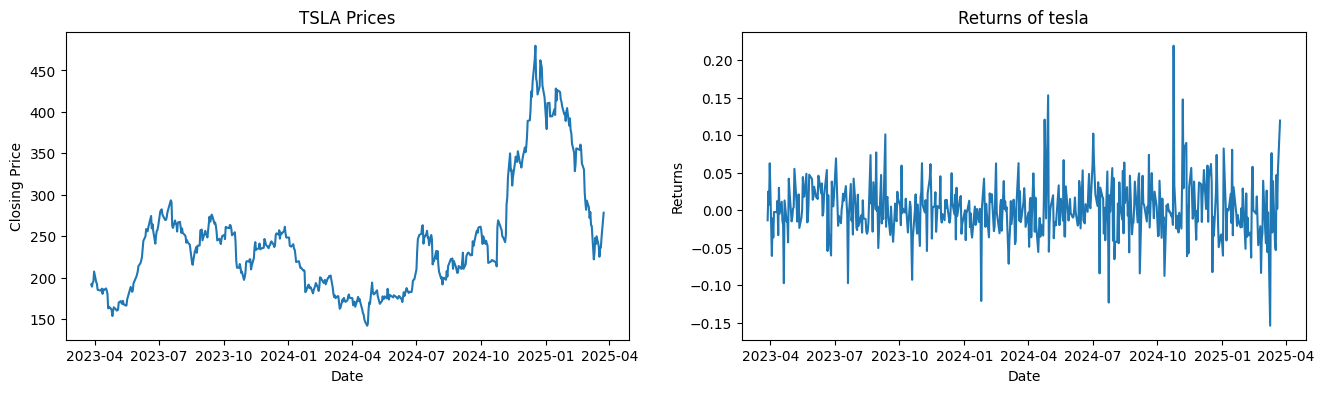

In [7]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(prices)
ax1.set_title("TSLA Prices")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price")

ax2.plot(returns)
ax2.set_title("Returns of tesla")
ax2.set_xlabel("Date")
ax2.set_ylabel("Returns")

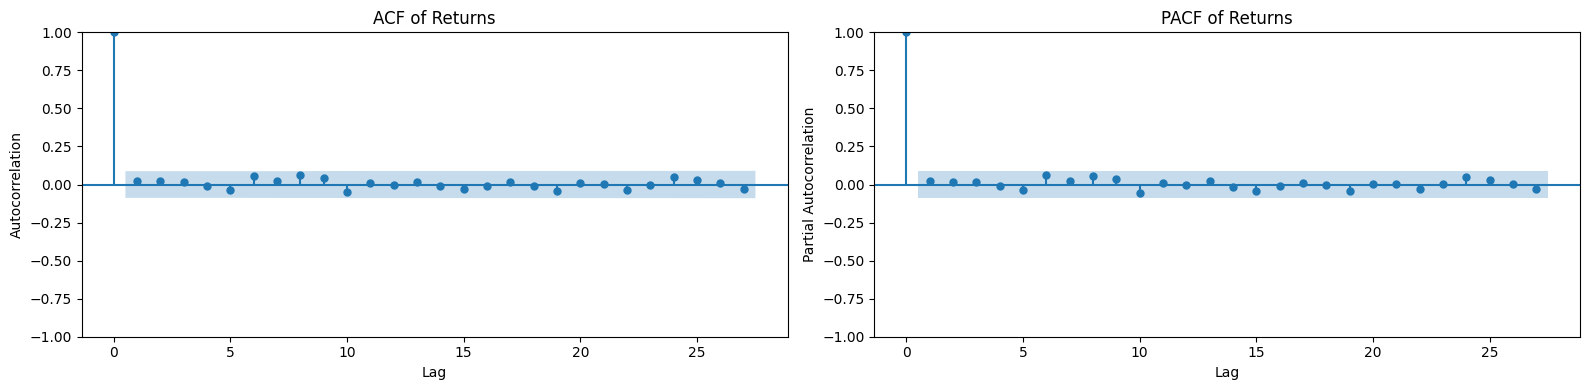

In [8]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF Plot
plot_acf(returns, ax=ax1)
ax1.set_title("ACF of Returns")
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")

# PACF Plot
plot_pacf(returns, ax=ax2, method='ywm')
ax2.set_title("PACF of Returns")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

# Stationary 

### ADF test (Augumented Dickey Fuller test) to check if the price series is stationary. 

Null hypothesis of the ADF test : time series is non-stationary.
So, if the p-value of the test is less than the significance level(0.05) then we can reject the null hypothesis and fer that time series is indeed stationary. 

In [9]:
#check if price series is stationary 
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.6197394662001998
p-value: 0.4728658885047596


### interpretation : p-value is clearly high, it means this time series is non stationary.
in our case, the p-value > 0.05 we'll need fo find the order of differencing.

## Fitting the ARIMA model

In [10]:
#building the model of ARIMA

model = ARIMA(prices, order=(10, 1, 1))
fitted = model.fit() 
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  500
Model:                ARIMA(10, 1, 1)   Log Likelihood               -1829.585
Date:                Tue, 25 Mar 2025   AIC                           3683.169
Time:                        11:38:17   BIC                           3733.720
Sample:                             0   HQIC                          3703.007
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1745      0.602     -0.290      0.772      -1.355       1.006
ar.L2          0.0223      0.035      0.632      0.527      -0.047       0.092
ar.L3         4.8e-05      0.043      0.001      0.9

(array([1.37155438e-03, 3.18029172e-02, 9.25799208e-03, 3.42888595e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.57221489e-05]),
 array([-41.50193248, -18.17073948,   5.16045353,  28.49164653,
         51.82283953,  75.15403254,  98.48522554, 121.81641855,
        145.14761155, 168.47880455, 191.80999756]),
 <BarContainer object of 10 artists>)

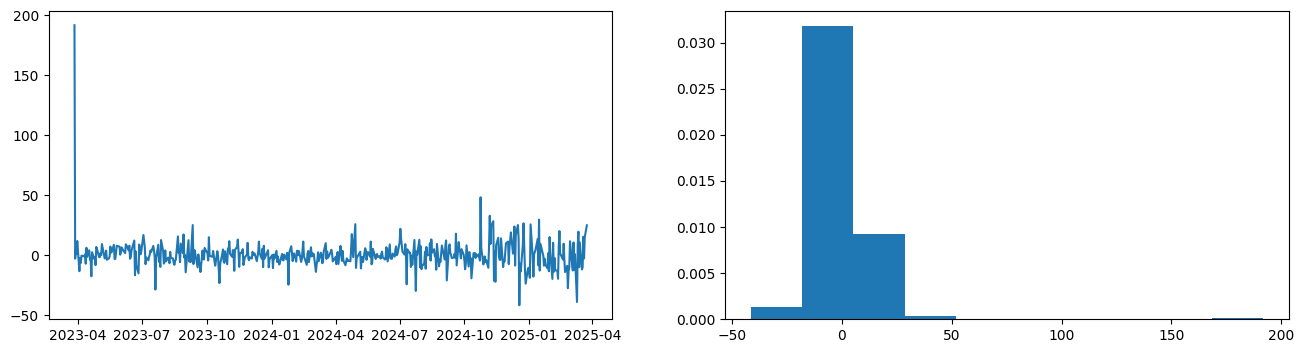

In [11]:
#Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

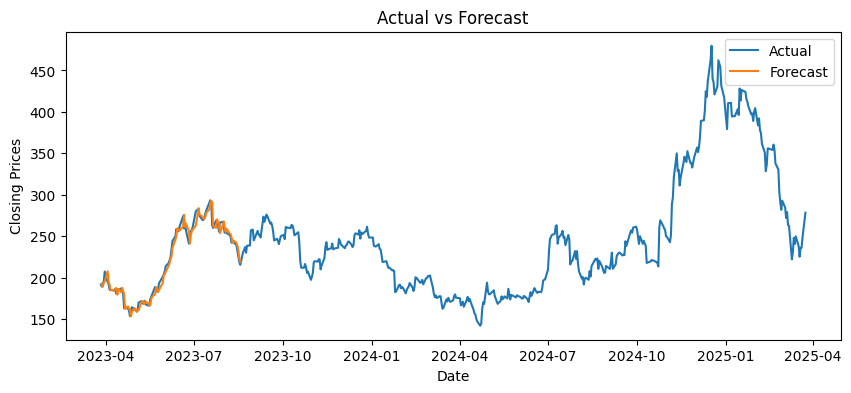

In [12]:
forecast = fitted.get_prediction(start=1, end=100, dynamic=False)
 
#actual vs forecast
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.plot(forecast.predicted_mean)
plt.ylabel("Closing Prices")

plt.xlabel("Date")
plt.title("Actual vs Forecast")
plt.legend(["Actual","Forecast"])



In [13]:
#prediction the next day price
next_day_price = fitted.forecast(100,alpha=0.05) # next 100days prediction, 95% of confidence level 
print(next_day_price)

500    279.721217
501    276.537307
502    277.494524
503    275.495162
504    275.394560
          ...    
595    284.611411
596    284.611411
597    284.611411
598    284.611411
599    284.611411
Name: predicted_mean, Length: 100, dtype: float64


In [14]:
predicted_price= next_day_price.values[0]
print(f"The predicted_price for {tomorrow} tomorrow:", predicted_price)

The predicted_price for 2025-03-26 tomorrow: 279.721216795103


<!-- ### Train test split --> -->

# Split train and test data

In [15]:
train = data.history(start='2023-01-01',end='2024-12-31')
test = data.history(start='2025-01-01',end='2025-12-31')

In [42]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Close'], order=(1,0,1))  # or (1,1,1)
fitted = model.fit()
fitted.summary()

forecast = fitted.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_mean.index = test.index  # 날짜 맞추기


In [43]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train['Close'], seasonal=False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3573.902, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3575.176, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3575.152, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3574.487, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3577.117, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.260 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  501
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1784.951
Date:                Tue, 25 Mar 2025   AIC                           3573.902
Time:                        11:41:16   BIC                           3582.331
Sample:                             0   HQIC                          3577.210
                                - 501                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6186      0.388      1.596      0.111      -0.141       1.378
sigma2        73.8419      2.721     27.134      0.000      68.508      79.176
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):               340.75
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train['Close'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=1,
                          seasonal=True,
                          m=12,  # 월별 주기면 12
                          trace=True,
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3576.527, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3573.902, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3577.050, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3577.042, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3574.487, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3575.788, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3575.802, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3573.087, Time=0.30 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3573.783, Time=0.73 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3576.661, Time=0.58 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3575.725, Time=0.37 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3575.561, Time=0.25 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3574.769, Time=0.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3574.527, Time=0.41 sec
 ARIMA(0,1,1)(1,0,1

In [45]:
model = ARIMA(train['Close'], order=(1,0,1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  501
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1791.707
Date:                Tue, 25 Mar 2025   AIC                           3591.415
Time:                        11:41:24   BIC                           3608.281
Sample:                             0   HQIC                          3598.033
                                - 501                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.8436     75.011      2.984      0.003      76.824     370.863
ar.L1          0.9963      0.005    214.335      0.000       0.987       1.005
ma.L1          0.0473      0.042      1.114      0.265      -0.036       0.131
sigma2        74.0428      2.749     26.930      0.000      68.654      79.432
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               332.60
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.52   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

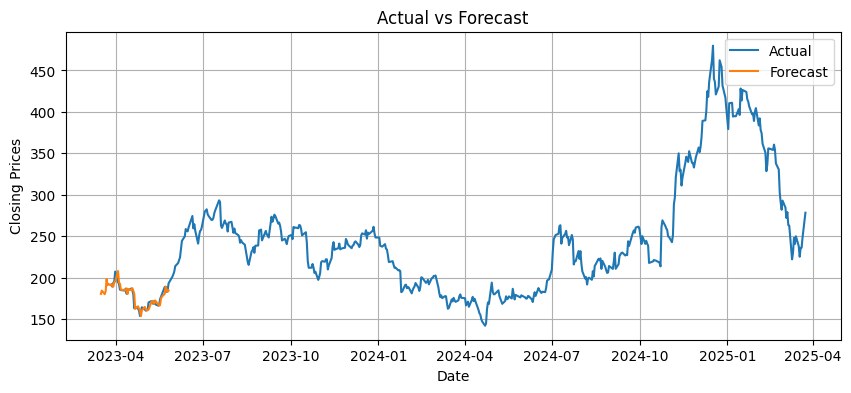

In [46]:
forecast = fitted.get_prediction(start=50, end=100, dynamic=False)
 
#actual vs forecast
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.plot(forecast.predicted_mean)
plt.ylabel("Closing Prices")

plt.xlabel("Date")
plt.title("Actual vs Forecast")
plt.legend(["Actual","Forecast"])
plt.grid(True)

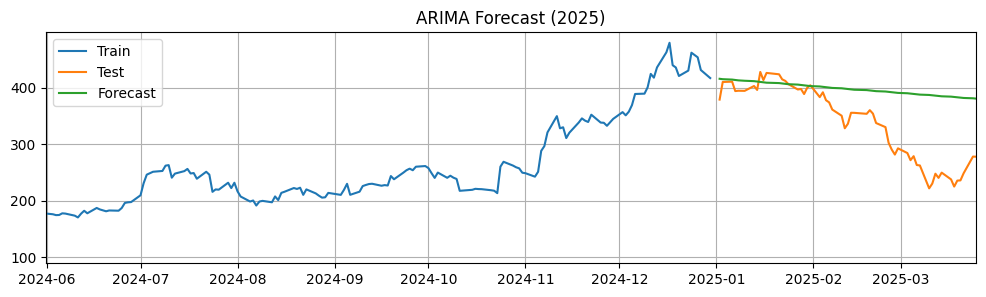

In [58]:
# test 길이만큼 미래 예측
n_periods = len(test)
forecast = fitted.get_forecast(steps=n_periods)
forecast_mean = forecast.predicted_mean

# 예측값 인덱스를 실제 2025년 날짜로 맞춰주기
forecast_mean.index = test.index

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3)) 
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, forecast_mean, label='Forecast')

plt.xlim(pd.to_datetime('2024-06-01'), test.index[-1])
plt.legend()
plt.title("ARIMA Forecast (2025)")
plt.grid(True)
plt.show()

In [48]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train['Close'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=1,
                          seasonal=False,
                          trace=True,
                          stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3577.117, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3573.902, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3575.176, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3575.152, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3574.487, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.085 seconds


In [49]:
stepwise_fit = auto_arima(train['Close'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=1,
                          seasonal=True,
                          m=12,  # 12개월 주기라면
                          trace=True,
                          stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3576.527, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3573.902, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3577.050, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3577.042, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3574.487, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3575.788, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3575.802, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3573.087, Time=0.31 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3573.783, Time=0.71 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3576.661, Time=0.61 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3575.725, Time=0.39 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3575.561, Time=0.26 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3574.769, Time=0.70 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3574.527, Time=0.40 sec
 ARIMA(0,1,1)(1,0,1

In [50]:
# from pmdarima.arima import auto_arima

# model2= auto_arima(train, seasonal =True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# fitted2= model2.fit(train)
# print(fitted2.summary())